<a href="https://colab.research.google.com/github/basselkassem/predict_income_potential/blob/master/model_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
data_path = "/content/gdrive/My Drive/Colab Notebooks/predict_income_potential/data/"
model_path = '/content/gdrive/My Drive/Colab Notebooks/predict_income_potential/models/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [9]:
!pip install catboost

     |████████████████████████████████| 62.9MB 135kB/s 


# Import libs

In [0]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline
import joblib
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Utile functions

In [0]:


cat_features = ['workclass', 'education_duration',
       'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country',
       'has_missing_values', 'com_workclass', 'com_marital_status',
       'com_native_country']
       
def preproc(X_train, X_val, X_test):
    input_list_train = []
    input_list_val = []
    input_list_test = []
    
    #the cols to be embedded: rescaling to range [0, # values)
    for c in cat_features:
        raw_vals = np.unique(X_train[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        input_list_train.append(X_train[c].map(val_map).values)
        input_list_val.append(X_val[c].map(val_map).fillna(0).values)
        input_list_test.append(X_test[c].map(val_map).fillna(0).values)
     
    #the rest of the columns
    other_cols = [c for c in X_train.columns if (not c in cat_features)]
    input_list_train.append(X_train[other_cols].values)
    input_list_val.append(X_val[other_cols].values)
    input_list_test.append(X_test[other_cols].values)
    
    return input_list_train, input_list_val, input_list_test

# Load data

In [3]:
data = pd.read_pickle(data_path + 'data_cont_cat_lb.pkl')
features = list(np.load(data_path + 'features.pkl.npy'))
print('data shape: ', data.shape)
print('features lenght: ', len(features))

data shape:  (48813, 39)
features lenght:  31


# Load base model

In [0]:
model_lrg = joblib.load(model_path + 'model_lrg.joblib')
model_gmm = joblib.load(model_path + 'model_gmm.joblib')
model_knn = joblib.load(model_path + 'model_knn.joblib')

In [0]:
model_catboost = CatBoostClassifier()
model_catboost.load_model(model_path + 'catboost_model.json', format = 'json')

model_lgbm = lgb.Booster(model_file = model_path + 'lgbm_model.txt')

In [0]:
from keras.models import load_model
from keras.models import model_from_json

json_file = open(model_path + 'nn_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_nn = model_from_json(loaded_model_json)
model_nn.load_weights(model_path + "nn_model_1.h5")

# Generate meta features

In [0]:
data = data[features + ['target']]
X, y = data.drop(columns = 'target'), data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)

In [0]:
X_train_list, X_val_list, X_test_list = preproc(X_train, X_val, X_test)

## Test meta features

In [0]:
y_test_lrg_hat = model_lrg.predict(X_test)
y_test_gmm_hat = model_gmm.predict(X_test)
y_test_knn_hat = model_knn.predict(X_test)
y_test_catboost_hat = model_catboost.predict(X_test)
y_test_lgbm_hat = model_lgbm.predict(X_test).round()
y_test_nn_hat = model_nn.predict(X_test_list).round()

In [0]:
X_test_level2 = np.c_[y_test_lrg_hat,
                      y_test_gmm_hat, 
                      y_test_knn_hat, 
                      y_test_catboost_hat,
                      #y_test_lgbm_hat, 
                      y_test_nn_hat,
                      ] 

In [156]:
X_test_level2.shape

(9763, 5)

## Validation meta features

In [0]:
y_val_lrg_hat = model_lrg.predict(X_val)
y_val_gmm_hat = model_gmm.predict(X_val)
y_val_knn_hat = model_knn.predict(X_val)
y_val_catboost_hat = model_catboost.predict(X_val)
y_val_lgbm_hat = model_lgbm.predict(X_val).round()
y_val_nn_hat = model_nn.predict(X_val_list).round()

In [0]:
X_val_level2 = np.c_[y_val_lrg_hat, 
                     y_val_gmm_hat,
                     y_val_knn_hat, 
                     y_val_catboost_hat,
                     y_val_lgbm_hat,
                     y_val_nn_hat,
                     ] 

In [174]:
X_val_level2.shape

(9763, 6)

## Train meta features

In [0]:
y_train_lrg_hat = model_lrg.predict(X_train)
y_train_gmm_hat = model_gmm.predict(X_train)
y_train_knn_hat = model_knn.predict(X_train)
y_train_catboost_hat = model_catboost.predict(X_train)
y_train_lgbm_hat = model_lgbm.predict(X_train).round()
y_train_nn_hat = model_nn.predict(X_train_list).round()

In [0]:
X_train_level2 = np.c_[y_train_lrg_hat, 
                       y_train_gmm_hat,
                       y_train_knn_hat, 
                       y_train_catboost_hat,
                       y_train_lgbm_hat, 
                       y_train_nn_hat,
                       ] 

In [177]:
X_train_level2.shape

(29287, 6)

# Stacking

In [0]:
cols = ['llrg', 
        'gmm', 
        'knn', 
        'catboost',
        'lgbm',
        'nn',]

In [0]:
X_test_level2 = pd.DataFrame(X_test_level2, columns=cols)
X_val_level2 = pd.DataFrame(X_val_level2, columns=cols)
X_train_level2 = pd.DataFrame(X_train_level2, columns=cols)

## Build meta model

In [180]:
meta_model = XGBClassifier(
    n_estimators = 2000,
   )

meta_model.fit(
    X_train_level2, 
    y_train, 
    eval_set = [(X_train_level2, y_train), (X_val_level2, y_val)], 
    verbose=True, 
    early_stopping_rounds = 10)

[0]	validation_0-error:0.098508	validation_1-error:0.12322
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.098508	validation_1-error:0.12322
[2]	validation_0-error:0.098508	validation_1-error:0.12322
[3]	validation_0-error:0.098508	validation_1-error:0.12322
[4]	validation_0-error:0.098508	validation_1-error:0.12322
[5]	validation_0-error:0.098508	validation_1-error:0.12322
[6]	validation_0-error:0.098508	validation_1-error:0.12322
[7]	validation_0-error:0.098508	validation_1-error:0.12322
[8]	validation_0-error:0.098508	validation_1-error:0.12322
[9]	validation_0-error:0.098508	validation_1-error:0.12322
[10]	validation_0-error:0.098508	validation_1-error:0.12322
Stopping. Best iteration:
[0]	validation_0-error:0.098508	validation_1-error:0.12322



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=2000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [181]:
y_train_hat = meta_model.predict(X_train_level2).round()
y_test_hat = meta_model.predict(X_test_level2).round()
tr_acc = accuracy_score(y_train, y_train_hat)
tr_f1 = f1_score(y_train, y_train_hat)
tr_auc = roc_auc_score(y_train, y_train_hat)

test_acc = accuracy_score(y_test, y_test_hat)
test_f1 = f1_score(y_test, y_test_hat)
test_auc = roc_auc_score(y_test, y_test_hat)
print('------train-----------')
print('accuracy_score: ', tr_acc)
print('f1_score: ', tr_f1)
print('roc_auc_score: ', tr_auc)
print('------test-------------')
print('accuracy_score: ', test_acc)
print('f1_score: ', test_f1)
print('roc_auc_score: ', test_auc)



------train-----------
accuracy_score:  0.9014921296138219
f1_score:  0.7776835940510133
roc_auc_score:  0.8399030640778926
------test-------------
accuracy_score:  0.7554030523404691
f1_score:  0.0
roc_auc_score:  0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[[7375    0]
 [2388    0]]


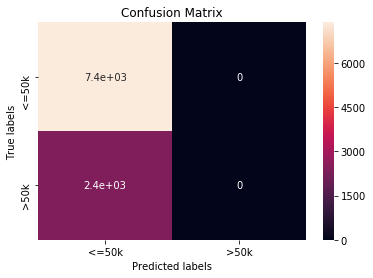

In [182]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
labels = [0, 1]
cm = confusion_matrix(y_test, y_test_hat, labels)
print(cm)
ax =  plt.subplot()
sns.heatmap(cm, annot = True, ax = ax);

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['<=50k', '>50k']); 
ax.yaxis.set_ticklabels(['<=50k', '>50k']);

In [183]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      7375
           1       0.00      0.00      0.00      2388

    accuracy                           0.76      9763
   macro avg       0.38      0.50      0.43      9763
weighted avg       0.57      0.76      0.65      9763



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
